This notebook provides an introduction for using a Variational Information Pursuit (V-IP) model to produce inherently interpretable predictions for mutagen classification tasks. Please refer to the paper for details about V-IP applied to mutagen classification.

In [7]:
import torch
import torch.nn.functional as F
from rdkit import Chem
import pandas as pd

from arch.mutagenicity import QuerierMutagenicity, ClassifierMutagenicity
from train_mutagenicity import evaluate
from mutagenicity_utils import mol_to_query_answers, create_posterior_prob_heatmap
from dataset import get_frag_query_map
import ops

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('DEVICE:', device)

DEVICE: cpu


### Produce an intepretable prediction for a molecule

Set the size of the queryset that was used for training the pre-trained V-IP model, and load model weights. Please see `README.md` for downloading the pre-trained model used in this notebook.

In [8]:
QUERYSET_SIZE = 407  # Set the size of the queryset used for training the model

model_path = './example_model.ckpt'
model = torch.load(model_path, weights_only=True, map_location=device)

classifier = ClassifierMutagenicity(queryset_size=QUERYSET_SIZE).to(device)
querier = QuerierMutagenicity(queryset_size=QUERYSET_SIZE, tau=1.0).to(device)

classifier.load_state_dict(model['classifier'])
querier.load_state_dict(model['querier'])

<All keys matched successfully>

Define an RDKit molecule. An example molecule is provided using SMILES. Make sure to sanitize the molecule using `rdkit.Chem.SanitizeMol()` and appropriate flags, since the the molecule will be passed to `rdkit.Chem.Fragments` module functions. The flags used during sanitization of molecules in the Mutagenicity dataset are:

``
Chem.SanitizeMol(mol, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SanitizeFlags.SANITIZE_ADJUSTHS)
``

Please see `mutagenicity_utils.nx_to_rdkit()` for further details.

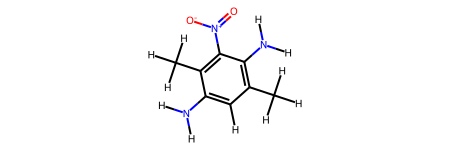

In [9]:
smiles = '[H]c1c(N([H])[H])c(C([H])([H])[H])c([N+](=O)[O-])c(N([H])[H])c1C([H])([H])[H]'
mol = Chem.MolFromSmiles(smiles, sanitize=False)
 
Chem.SanitizeMol(mol, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^
                                  Chem.SanitizeFlags.SANITIZE_ADJUSTHS)

mol

If you haven't already, download the Mutagenicity dataset and generate the queryset by running `generate_queryset.py`. Please refer to the `README.md` for instructions on how to do this. 

Next, load the queryset that was used for training the V-IP model (for the example model in this notebook, use the queryset generated by `generate_queryset.py`). For the molecule previously defined, compute answers to all queries in the given queryset. 

NOTE: If you will train a model using a different queryset, it must have the same format as the querysets generated by `generate_queryset.py`   

In [10]:
QUERY_SET_PATH = './data/rdkit_queryset.csv'
queryset = pd.read_csv(QUERY_SET_PATH)

frag_query_map = get_frag_query_map(queryset)
qry_ans = mol_to_query_answers(mol, frag_query_map, device)

Evaluate the model on the defined molecule.

In [11]:
params = {
    'test_features': qry_ans,
    'querier': querier,
    'classifier': classifier,
    'n_queries': QUERYSET_SIZE,
    'max_queries_test': 20,  # Maximum number of queries to be made during evaluation, can increase if needed
}
logits, queries = evaluate(**params)

V-IP sequentially asks user-interpretable queries about the data until a prediction can be made with some sufficient level of confidence. After every query asked, the model makes a prediction on the class label using ONLY the current query asked and all the queries asked before it as input (the "history" of queries). It will as queries until it makes a class prediction that surpasses a predefined class probability threshold, resulting in a sequence of queries and answers that provide full transparency about the model's decision-making process. The class prediction made after the final query is asked is the model's final prediction. In this example, a query is the number of occurrences of a functional group (i.e. specific node-induced subgraph) in a molecule, and the answer to the query is *YES* or *NO*.

The V-IP predictions and interpretable query-answer sequences for a molecule can be visualized using a heatmap of the class softmax probabilities given the history of queries asked until a certain row in the heatmap. The querying terminates when one of the class probabilities surpasses the chosen confidence threshold. 

Define the variable `CONFIDENCE_THRESHOLD` and run the cell to visualize the sequence of queries asked and the associated changes in class probabilities in the form of a class probability heatmap. Refer to *Figure 5b* in  for a method of testing different confidence thresholds on a test dataset.

A query $q_i$ will have the form `q<i>: <functional_group_name>=<num_of_occurences>?`.

For example, the query `q2: benzene=2?` is read as **Query #2:** *Are there 2 benzene functional groups present in the molecule?*"

In the visualization, a query is coloured <span style="color:green">GREEN</span> or <span style="color:red">RED</span> to represent a *YES* or *NO* answer to the query respectively.

Abbreviations for functional group names follow the names used in the `rdkit.Chem.Fragments` module. Please refer to their documentation for more information about the functional groups: https://rdkit.org/docs/source/rdkit.Chem.Fragments.html

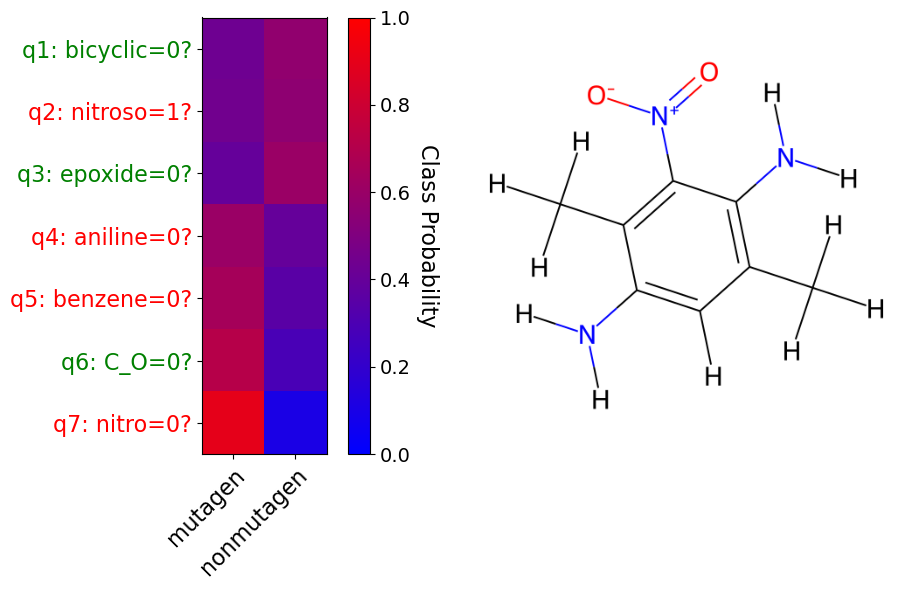

In [12]:
CONFIDENCE_THRESHOLD = 0.85

num_queries_needed_ip = ops.compute_queries_needed(logits, CONFIDENCE_THRESHOLD)
probs = F.softmax(logits, dim=2)
probs_ip = probs[0, 0:num_queries_needed_ip, :]
queries_ip = queries[0, 0:num_queries_needed_ip, :]


# Visulaization
params = {
    'mol': mol,
    'probs': probs_ip,
    'queries': queries_ip,
    'answers': qry_ans[0],
    'threshold': CONFIDENCE_THRESHOLD,
    'show_funcgroups_in_mol': False,  # Set to True to visualize enumeration of all functional groups in the molecule
    'queryset_path': QUERY_SET_PATH,
}
fig, ax = create_posterior_prob_heatmap(**params)

### Qualitative interpretation of prediction

- **q1:** The model seems to have learned that the presence of a bicyclic functional group is the most informative query to ask first. Our example molecule has no bicyclic, and the model learned that molecules without bicyclic have a higher probability of being non-mutagenic, as seen by the higher probability for the non-mutagenic class in the corresponding cell of the heatmap.

- **q2:** The second query tells us that *not* having 1 nitroso group (excluding NO2) increases slightly increases confidence that the molecule is mutagenic, given the answer to q1 (0 occurences of biclycic in molecule). Although, this doesn't tell us whether having 0 or more than 1 nitroso groups (excluding NO2) would increase confidence in either class. More simply, q2 is not sufficient for telling us whether it is simply the lack of presense of the nitroso group (excluding NO2) that increases confidence in mutagenicity, or whether the exact number of occurences of the group matters.

- **q3:** The lack of epoxide groups present in the molecule increases confidence in the non-mutagenic class, given the answers to q1 and q2.

- **q4:** The presence of aniline in the molecule increases confidence in the mutagenic class, given answers to q1,...,q3, now making mutagenic the most probable class. 

- **q5:** The presence of benzene in the molecule further increases confidence in the mutagenic classs, given answers to q1,...,q4.

- **q6:** The lack of carbonyl O groups present in the molecule further increases confidence in the mutagenic class, given the answers to q1,...,q5.

- **q7:** The presence of a nitro group in the molecule further increases confidence in the mutagenic classs, given answers to q1,...,q6. The class probability for the mutagenic class surpasses the chosen confidence threshold of 0.85, and the final prediction is that our example molecule is *mutagenic*.